**Machine Learning Basic Principles 2018 - Data Analysis Project Report**

# Support Vector Machines in Music Genre Classification

## Abstract

Automatic music genre classification (AMGC) is a widely used technique in nowadays' music services. The problem of automatic genre classification is multifold: data is often not perfect and there is no clear distinction between genres. The focus in this research is to build a classifier which is able to distinguish samples of music features in correct genres. The problem consists of 10 classes, so a "1 vs all" approach is adopted. After processing, analysing and visualising the training data, a support vector machine (SVM) classifier is proposed. SVM seemed to fit the problem well and produced the best results out of the multiple different classifiers which were tested. The best performing SVM classifier was able to predict the correct genre with $0.65766$ accuracy with LogLoss of $0.16711$.



## 1. Introduction

Music streaming services of today use automatic music genre classification (AMGC) techniques extensively. Genre classification is a challenging task which requires deep analysis of the different properties in music samples and machine learning. Often there is no clear distinction between genres so accurate and objective classification is not a trivial task. Correct music classification is an important task as classifying music manually is very time consuming and prone to errors. This research aims to produce a viable music genre classifier which is able to classify music samples to correct genres by analysing the features of the samples.

The research question is, which kind of a classifier has the best performance in a music genre classification problem (Jung, 2018). Conducting this research, we hope to learn about machine learning in general, which kind of machine learning algorithms provide the best results for the task at hand and what kind of machine learning algorithms are used in similar tasks.

The project goal is to get hands on experience with a real classification problem and test the methods that we have learned during the Machine Learning Basic Principles course. Though, the solutions for the problem are not limited to the course material.


## 2. Data analysis

The provided training data consists of $N=4363$ music samples each consisting of $d=264$ features. The training samples belong to $M=10$ classes labeled as different music genres. The data is acquired from The Million Song Dataset (Bertin-Mahieux, 2011). The features can be divided into three sub categories: rhythm, chroma and MFCC.

### 2.1. Data loading
In this section the data is loaded and appropriate data matrices are formed.

In [21]:
# Clear variables from global namespace.
%reset -f

In [22]:
# Import libraries.
import datetime
import itertools
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import display
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

In [23]:
# Load the training data.
df_train = pd.read_csv('train_data.csv')
df_labels = pd.read_csv('train_labels.csv')

# Load the test data.
df_test = pd.read_csv('test_data.csv', header=None)

# Create feature matrix from all training data.
train_matrix = np.array(df_train)

# Create label vector.
label_vector = np.array(df_labels)

# Create train_matrix from all test data.
test_matrix = np.array(df_test)

# Do some preprocessing scaling.
scaler = StandardScaler()
train_matrix = scaler.fit_transform(train_matrix)
test_matrix = scaler.transform(test_matrix)

# Append labels to the end of the feature matrix.
labeled_train_matrix = np.append(train_matrix, label_vector, axis=1)

# Separate feature vectors by genre.
pop_rock = labeled_train_matrix[np.where( labeled_train_matrix[:,-1] == 1.0)]
electronic = labeled_train_matrix[np.where( labeled_train_matrix[:,-1] == 2.0)]
rap = labeled_train_matrix[np.where( labeled_train_matrix[:,-1] == 3.0)]
jazz = labeled_train_matrix[np.where( labeled_train_matrix[:,-1] == 4.0)]
latin = labeled_train_matrix[np.where( labeled_train_matrix[:,-1] == 5.0)]
rnb = labeled_train_matrix[np.where( labeled_train_matrix[:,-1] == 6.0)]
international = labeled_train_matrix[np.where( labeled_train_matrix[:,-1] == 7.0)]
country = labeled_train_matrix[np.where( labeled_train_matrix[:,-1] == 8.0)]
reggae = labeled_train_matrix[np.where( labeled_train_matrix[:,-1] == 9.0)]
blues = labeled_train_matrix[np.where( labeled_train_matrix[:,-1] == 10.0)]

# Group all genres to a dictionary.
genres = {
    'pop_rock' : pop_rock,
    'electronic' : electronic,
    'rap' : rap,
    'jazz' : jazz,
    'latin' : latin,
    'rnb' : rnb,
    'international' : international,
    'country' : country,
    'reggae' : reggae,
    'blues' : blues
}

# Dictionary for the different feature types (rhythm, chroma, MFCC) and ranges.
# The shapes are: "bands x statistics".
feature_ranges = {
    'rhythm' : np.arange(0,168).reshape((24,7)),
    'chroma' : np.arange(168,216).reshape((12,4)),
    'mfcc' : np.arange(216,264).reshape((12,4))
}

In [24]:
# Function which prints correct Kaggle 'accuracy' submission format.
def print_kaggle_accuracy_format(predictions):
    result = "Sample_id,Sample_label\n"
    for i in range(0,len(predictions)):
        result = result + (str(i+1) + "," + str(predictions[i]) + "\n")
    now = datetime.datetime.now()
    file_suffix = str(now.year) + str(now.month) + str(now.day) + str(now.hour) + str(now.minute) + str(now.second)
    text_file = open("Solutions/accuracy/solution_" + file_suffix + ".csv", "w")
    text_file.write(result)
    text_file.close()

# Function which prints correct Kaggle 'logloss' submission format.
def print_kaggle_logloss_format(predictions):
    result = "Sample_id,Class_1,Class_2,Class_3,Class_4,Class_5,Class_6,Class_7,Class_8,Class_9,Class_10\n"
    for i in range(predictions.shape[0]):
        result += (str(i+1))
        for j in range(predictions.shape[1]):
            result += "," + str("%.4f" % predictions[i, j])
        result += "\n"
    now = datetime.datetime.now()
    file_suffix = str(now.year) + str(now.month) + str(now.day) + str(now.hour) + str(now.minute) + str(now.second)
    text_file = open("Solutions/logloss/solution_" + file_suffix + ".csv", "w")
    text_file.write(result)
    text_file.close()

# Function for plotting confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

### 2.2. Data visualization
The class distribution is not uniform as can be seen in class distribution histogram below. Because there is substantial class imbalance some genres may be harder to distinguish from the samples than others.

For visualization purposes some means of features are presented below the distribution histogram.

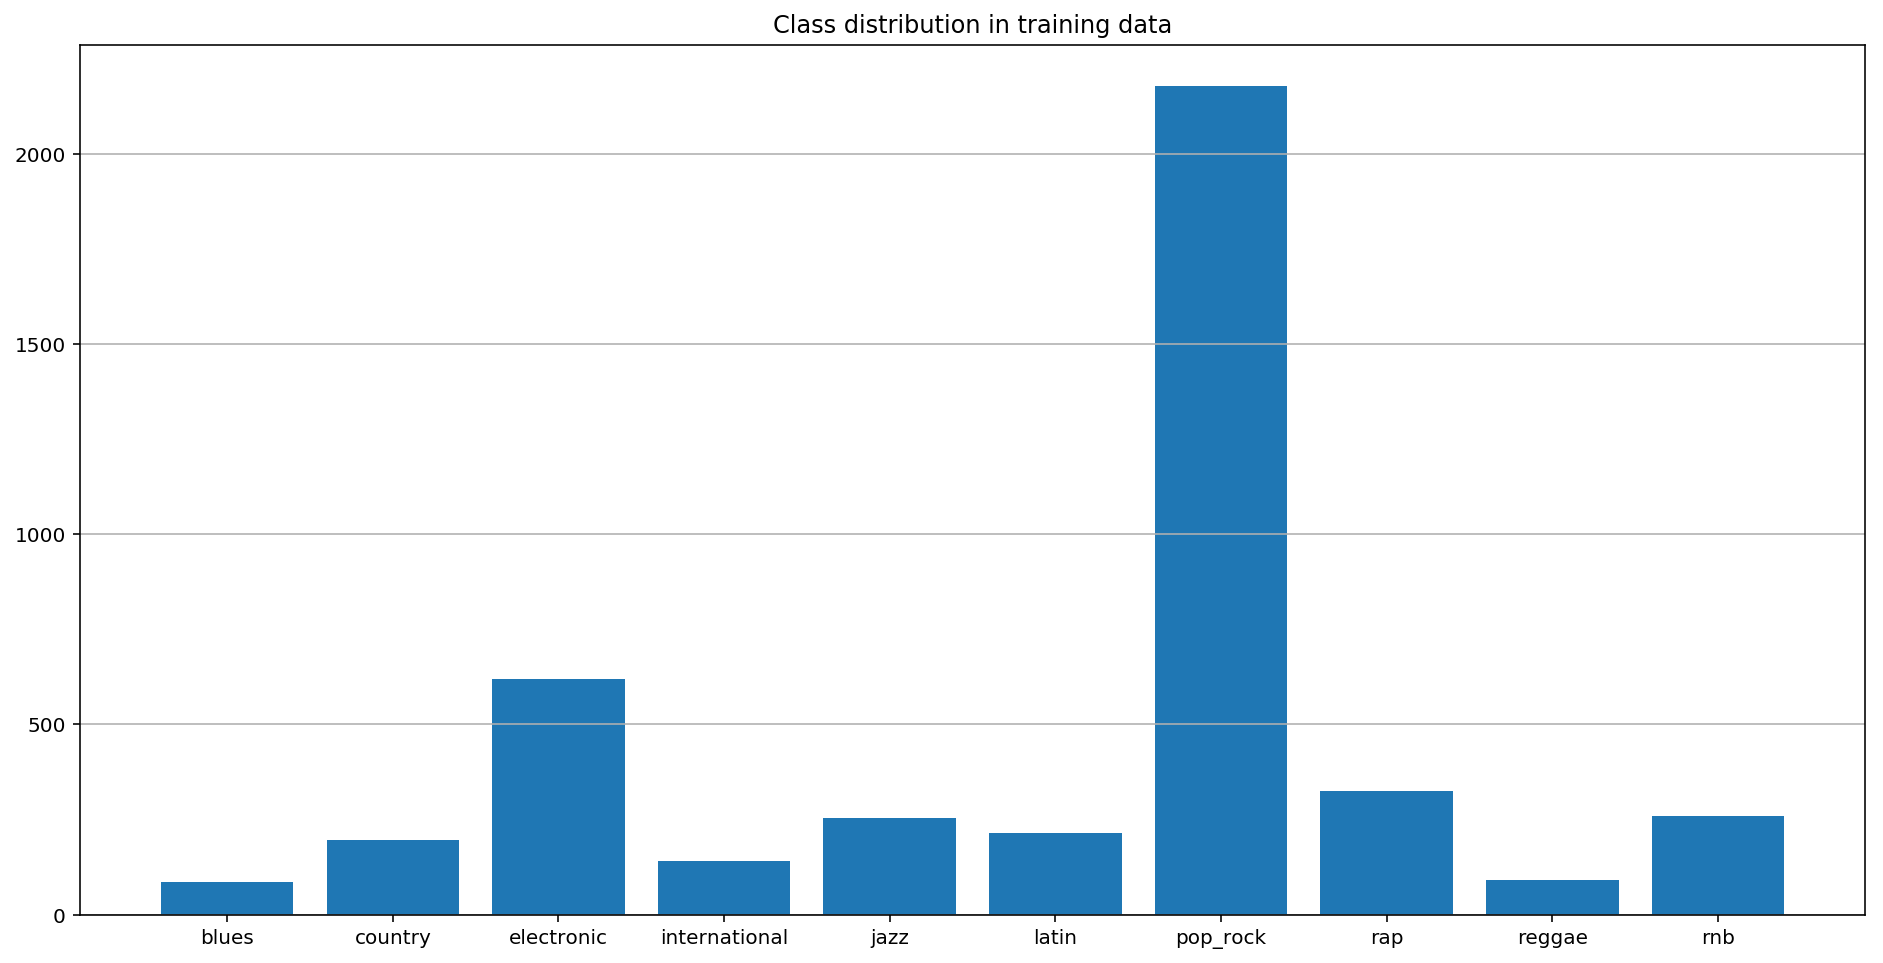

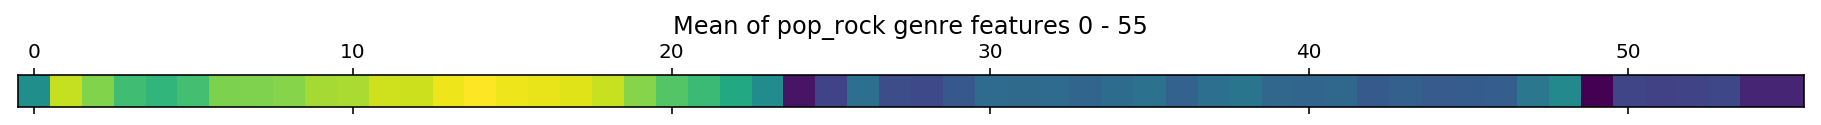

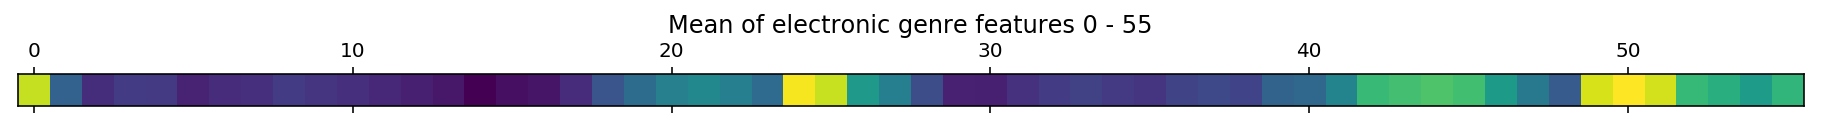

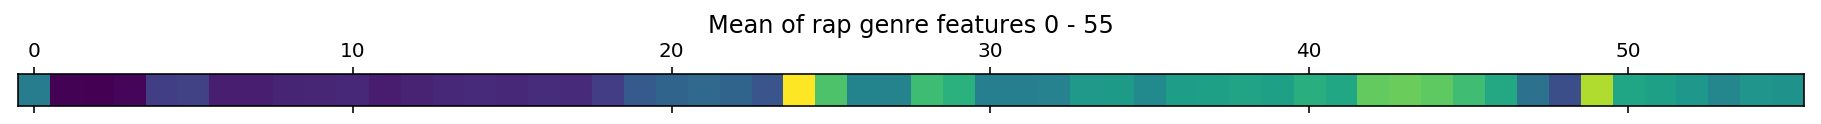

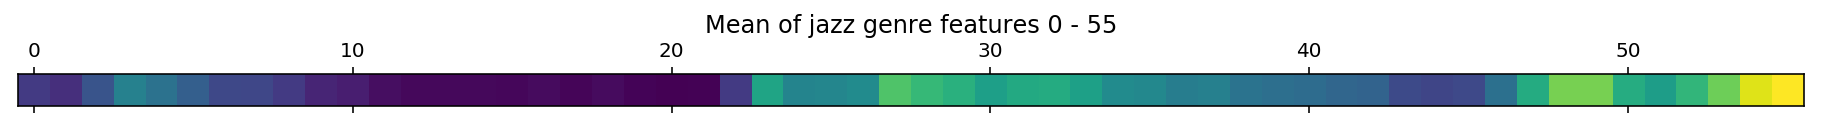

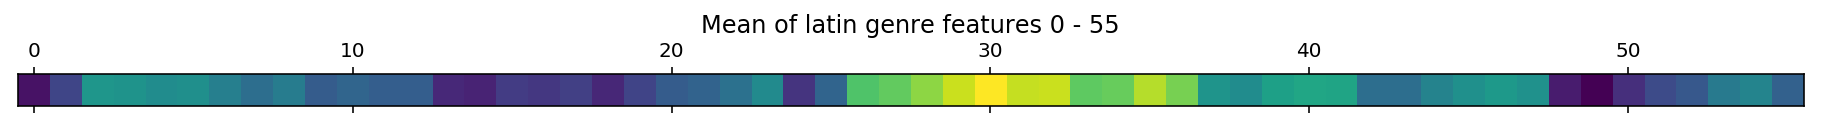

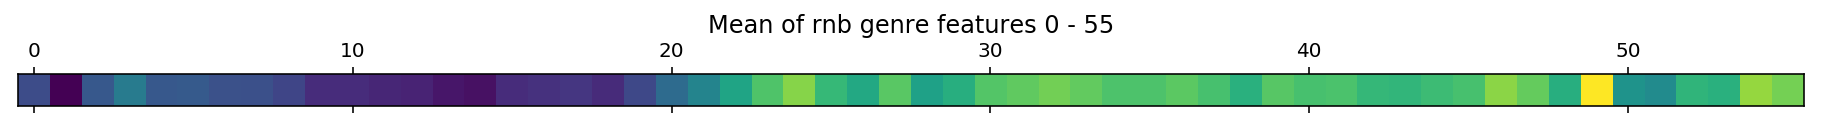

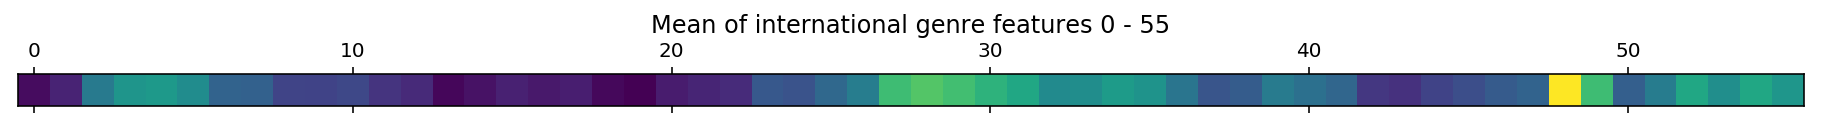

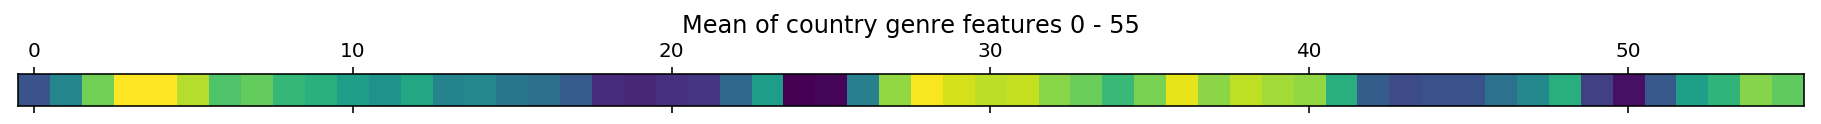

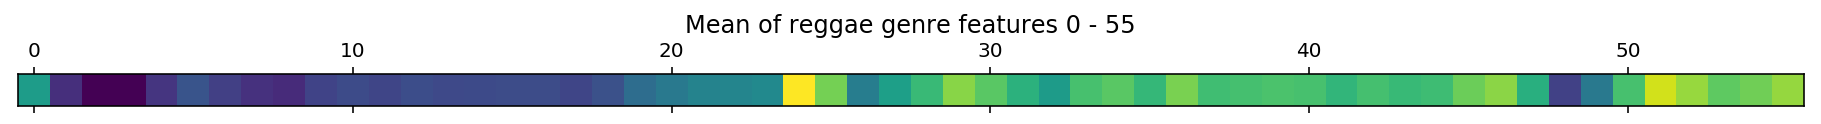

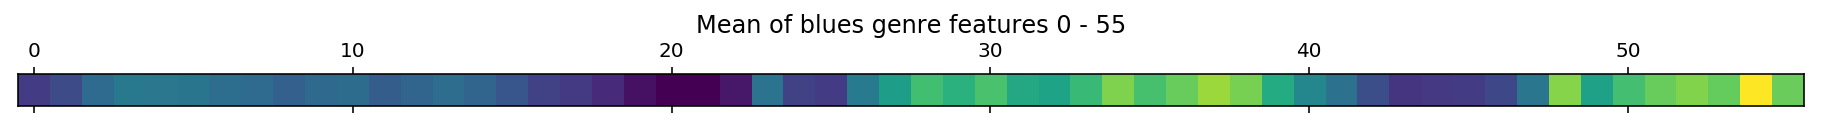

In [25]:
# Visualization of the input data.

# Function which plots bar graph of class distribution.
def plot_class_distribution():
    class_distribution = []
    for genre in genres:
        class_distribution.append((len(genres.get(genre))))
    x = []
    for genre in genres:
        x.append(str(genre))
    plt.figure(figsize=(16,8))
    plt.grid(True, axis='y')
    plt.title('Class distribution in training data')
    plt.bar(x, class_distribution)

# Function which plots the mean feature values per genre.
# Input: numeric array of features, such as: [0,1,2,..,12].
def plot_features(feature_range):
    feature_range = feature_range.flatten()
    for genre in genres:
        genre_data = genres.get(genre)
        feature_mean = genre_data[:, feature_range].sum(axis=0)
        minima = np.min(feature_mean)
        maxima = np.max(feature_mean)
        feature_mean = feature_mean.reshape((1, feature_range[-1]-feature_range[0]+1))
        plt.matshow(feature_mean)
        plt.title('Mean of ' + genre + ' genre features ' + str(feature_range[0]) + ' - ' + str(feature_range[-1]) + '\n')
        plt.gca().axes.get_yaxis().set_visible(False)

plot_class_distribution()
plot_features(feature_ranges['rhythm'][0:8,:])

### 2.3. A look on dimensionality reduction
Feature visualization can be found in the PCA section below. Due to quite high reconstruction error even with large ($d=110$) amount of PCA components, PCA reduction does not seem to bring many benefits.

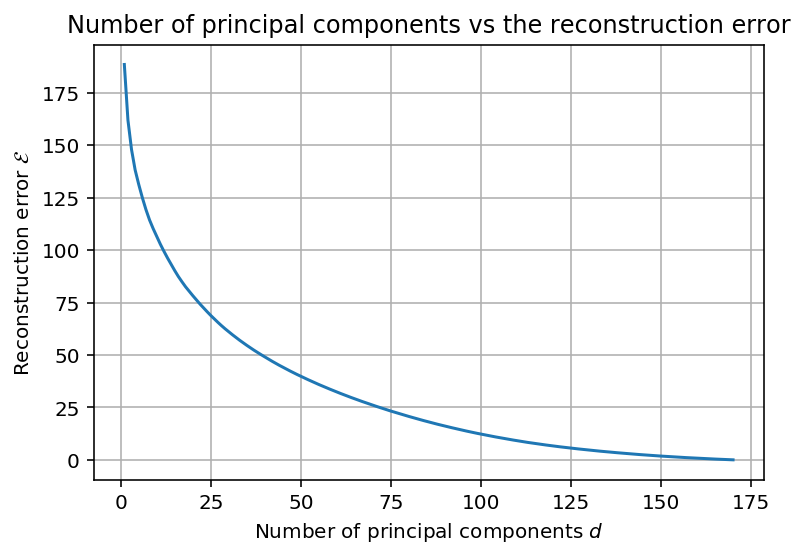

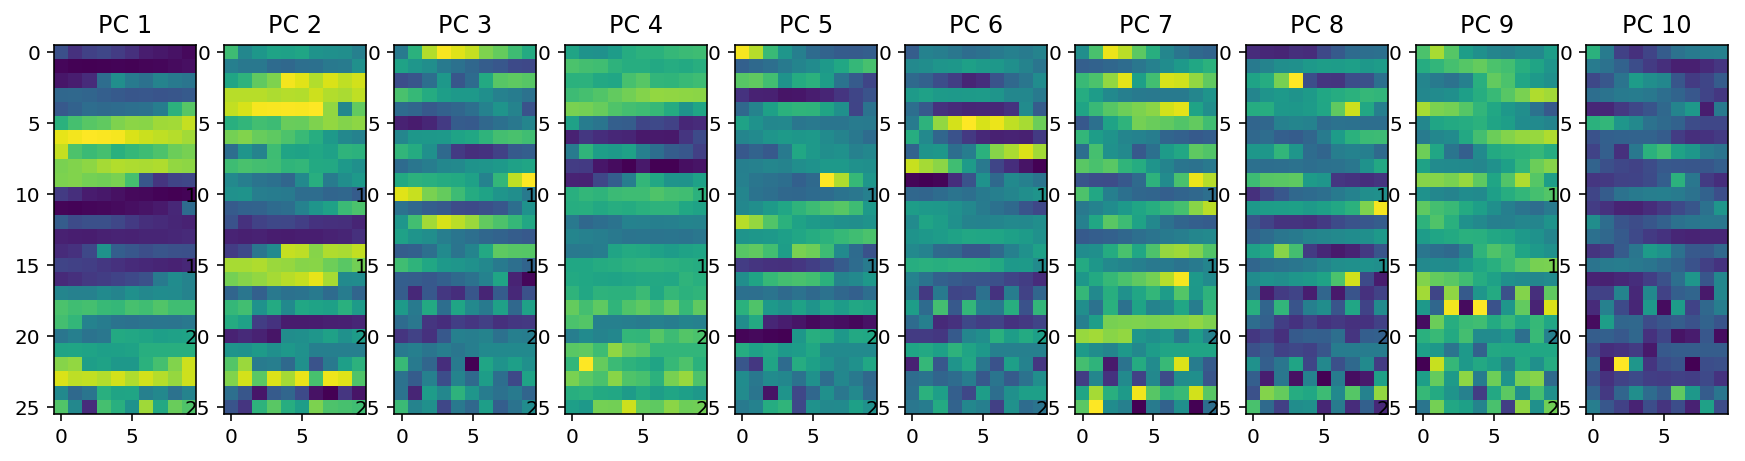

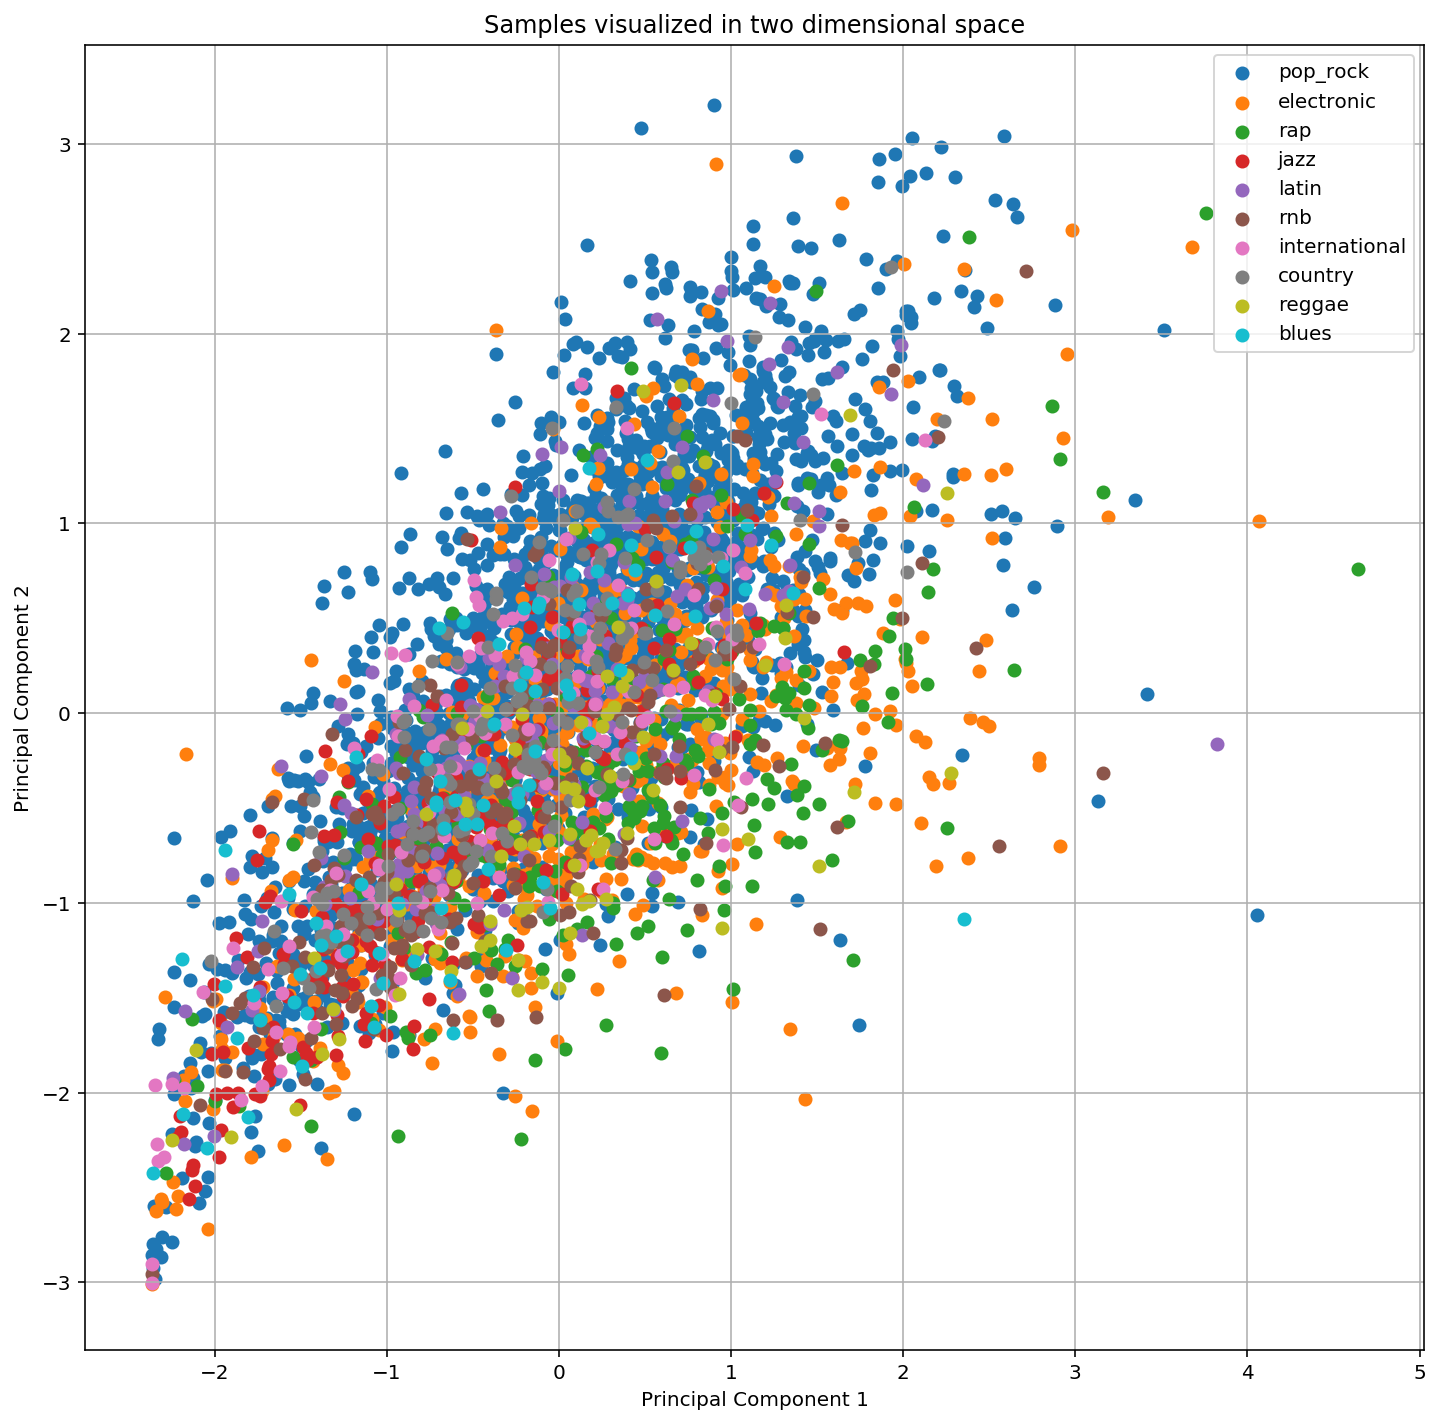

In [26]:
# PCA reduction
def compute_pca(Z, d):
    Q = np.dot(np.transpose(Z), Z) * (1/Z.shape[0])
    eigvals, eigvecs = np.linalg.eig(Q)
    eigvecs = np.transpose(eigvecs)
    indexes = np.argsort(eigvals)[::-1]
    wanted_indexes = indexes[0:d]
    W_pca = eigvecs[wanted_indexes]
    return W_pca.real, eigvals[wanted_indexes]

def plot_error(eigvalues, max_d):
    x=range(1,max_d+1)
    errors=[sum(eigvalues[d:]) for d in x]
    plt.plot(x,errors)
    plt.xlabel('Number of principal components $d$')
    plt.ylabel('Reconstruction error $\mathcal{E}$')
    plt.title('Number of principal components vs the reconstruction error')
    plt.grid(True)
    plt.show()

def plot_princ_comp(PCA, x, y):
    fig,ax = plt.subplots(1,10,figsize=(15,15))
    plot_pd = [0,1,2,3,4,5,6,7,8,9]
    for i in range(len(plot_pd)):
        ax[i].imshow(np.reshape(PCA[plot_pd[i]]*255,(y,x)))
        ax[i].set_title("PC %d"%(plot_pd[i]+1))
    plt.show()

def visualize_pca(labeled_pca_train_matrix):
    pop_rock = labeled_train_matrix[np.where( labeled_pca_train_matrix[:,-1] == 1.0)]
    electronic = labeled_train_matrix[np.where( labeled_pca_train_matrix[:,-1] == 2.0)]
    rap = labeled_train_matrix[np.where( labeled_pca_train_matrix[:,-1] == 3.0)]
    jazz = labeled_train_matrix[np.where( labeled_pca_train_matrix[:,-1] == 4.0)]
    latin = labeled_train_matrix[np.where( labeled_pca_train_matrix[:,-1] == 5.0)]
    rnb = labeled_train_matrix[np.where( labeled_pca_train_matrix[:,-1] == 6.0)]
    international = labeled_train_matrix[np.where( labeled_pca_train_matrix[:,-1] == 7.0)]
    country = labeled_train_matrix[np.where( labeled_pca_train_matrix[:,-1] == 8.0)]
    reggae = labeled_train_matrix[np.where( labeled_pca_train_matrix[:,-1] == 9.0)]
    blues = labeled_train_matrix[np.where( labeled_pca_train_matrix[:,-1] == 10.0)]
    labels = labeled_pca_train_matrix[:,-1]
    fig = plt.figure(figsize=((12,12)))
    ax = fig.add_subplot(111)
    ax.scatter(pop_rock[:,0], pop_rock[:,1], label='pop_rock')
    ax.scatter(electronic[:,0], electronic[:,1], label='electronic')
    ax.scatter(rap[:,0], rap[:,1], label='rap')
    ax.scatter(jazz[:,0], jazz[:,1], label='jazz')
    ax.scatter(latin[:,0], latin[:,1], label='latin')
    ax.scatter(rnb[:,0], rnb[:,1], label='rnb')
    ax.scatter(international[:,0], international[:,1], label='international')
    ax.scatter(country[:,0], country[:,1], label='country')
    ax.scatter(reggae[:,0], reggae[:,1], label='reggae')
    ax.scatter(blues[:,0], blues[:,1], label='blues')
    ax.legend()
    ax.grid(True)
    ax.set_title('Samples visualized in two dimensional space')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    plt.show()

# Analysis on all features.
num_components = 170
PCA_all, eigvalues_all = compute_pca(train_matrix[:,0:264], num_components)
plot_error(eigvalues_all, num_components)
plot_princ_comp(PCA_all[:,0:260], 10, 26)
pca_train_matrix = np.dot(train_matrix, np.transpose(PCA_all))
labeled_pca_train_matrix = np.append(pca_train_matrix, label_vector, axis=1)
visualize_pca(labeled_pca_train_matrix)


## 3. Methods and experiments

In the experiments multiple different classifier types were tested, e.g. Support Vector Machine (SVM), Stochastic Gradient Descent (SGD), Multi-Layer Perceptron (MLP). The algorithms used in experiments are heavily based on the algorithms provided by scikit-learn machine learning library.

For many of the tested classifier algorithms, a differing set of parameters need to be passed. It was found that different parameter values have a substantial effect on the performance of the classifiers. Due to this, the focus in these experiments were on finding well performing parameter values for classifiers. This requires exhaustive trial-and-error search.

Python libraries makes it easy finding the best accuracy producing parameter combinations. In particular, module GridSearchCV from the model selection library of scikit proved to be helpful in finding good parameter combinations. According to the name of the module, GridSearchCV uses cross validation when validating the result. For our purposes, folding 5 times for cross validation was used.

For finding a good penalty parameter $C$ and kernel coefficient $gamma$ for an SVM, the following snippet was used (warning, grid search may take a long time):

In [27]:
# Use GridSearchCV to determine the best parameters.
C_params = np.linspace(1, 5, 3)
gamma_params = np.linspace(0.001, 0.004, 3)
parameters = {'C' : C_params, 'gamma' : gamma_params}
svc = svm.SVC()
clf = GridSearchCV(svc, parameters, cv=5)
clf.fit(labeled_train_matrix[:,0:-1], labeled_train_matrix[:,-1])

# Printing the results in the end to find out which parameter value(s) performed the best.
print(clf.cv_results_['mean_test_score'])
clf.cv_results_['params']

[0.61921137 0.63273728 0.63548831 0.64718019 0.66254012 0.66047685
 0.65772581 0.65726731 0.65589179]


[{'C': 1.0, 'gamma': 0.001},
 {'C': 1.0, 'gamma': 0.0025},
 {'C': 1.0, 'gamma': 0.004},
 {'C': 3.0, 'gamma': 0.001},
 {'C': 3.0, 'gamma': 0.0025},
 {'C': 3.0, 'gamma': 0.004},
 {'C': 5.0, 'gamma': 0.001},
 {'C': 5.0, 'gamma': 0.0025},
 {'C': 5.0, 'gamma': 0.004}]

Preprocessing turned out to be important for the standardized machine learning estimators, which are working badly if the features are not in standardized and normally distributed form. For example, Support Vector Machines (SVM) with linear or radial basis function (RBF) kernel are assuming that all features are zero mean and have the same order variance. (Scikit-learn, 2018)

SVM Classifier tuning was also important part of the project. Scikit C-Support Vector Classification function provides three options for kernel algorithm: RBF, linear and polynomial. (Scikit-learn, 2018) All of these were tested and RBF and linear kernel algorithms were giving the best results.

For the non-linear RBF kernel, the scikit SVC funtion allowed parameter tuning with gamma and C parameters. With higher values of gamma the function is trying to exactly fit the data points and with lower values of gamma the function boundaries try to keep as far from the data points as possible. The C parameter is tuning the tradeoff between smooth curvature of the decision boundary and the correct classification. Too high C values might lead to overfitting. (Fraj, 2018)

If gamma option "scale" in the SVC function is applied the gamma parameter is calculated with a formula $1 / (n_f * X.std())$, where $n_f$ is a number of features and $X.std()$ is a standard deviation of the train matrix. This was used as a starting point for the gamma tuning with the SVC.

One versus all strategy was studied for this project. In one versus all strategy the multi-class problem is divided to smaller problems of binary classification. This means that every music sample is tested as many times as there are classes and each of them tests if the sample belongs to the certain class or not. As default the scikit SVC funtion uses one versus one classification strategy as multi-class strategy but it can be wrapped with OVR classifier so that one versus rest strategy is used. Although, this was not showing any additional benefit regarding the accuracy or logloss tests.

## 4. Results

### 4.1. The best performing classifier
After experimenting on multiple classifiers, an SVM using RBF kernel performed the best. In particular, parameters $C=3.2$ and $gamma=0.0025$ resulted in the best score. The best performing classifier and the confusion matrix can be found below.

Accuracy score on test data: 0.7020997375328084


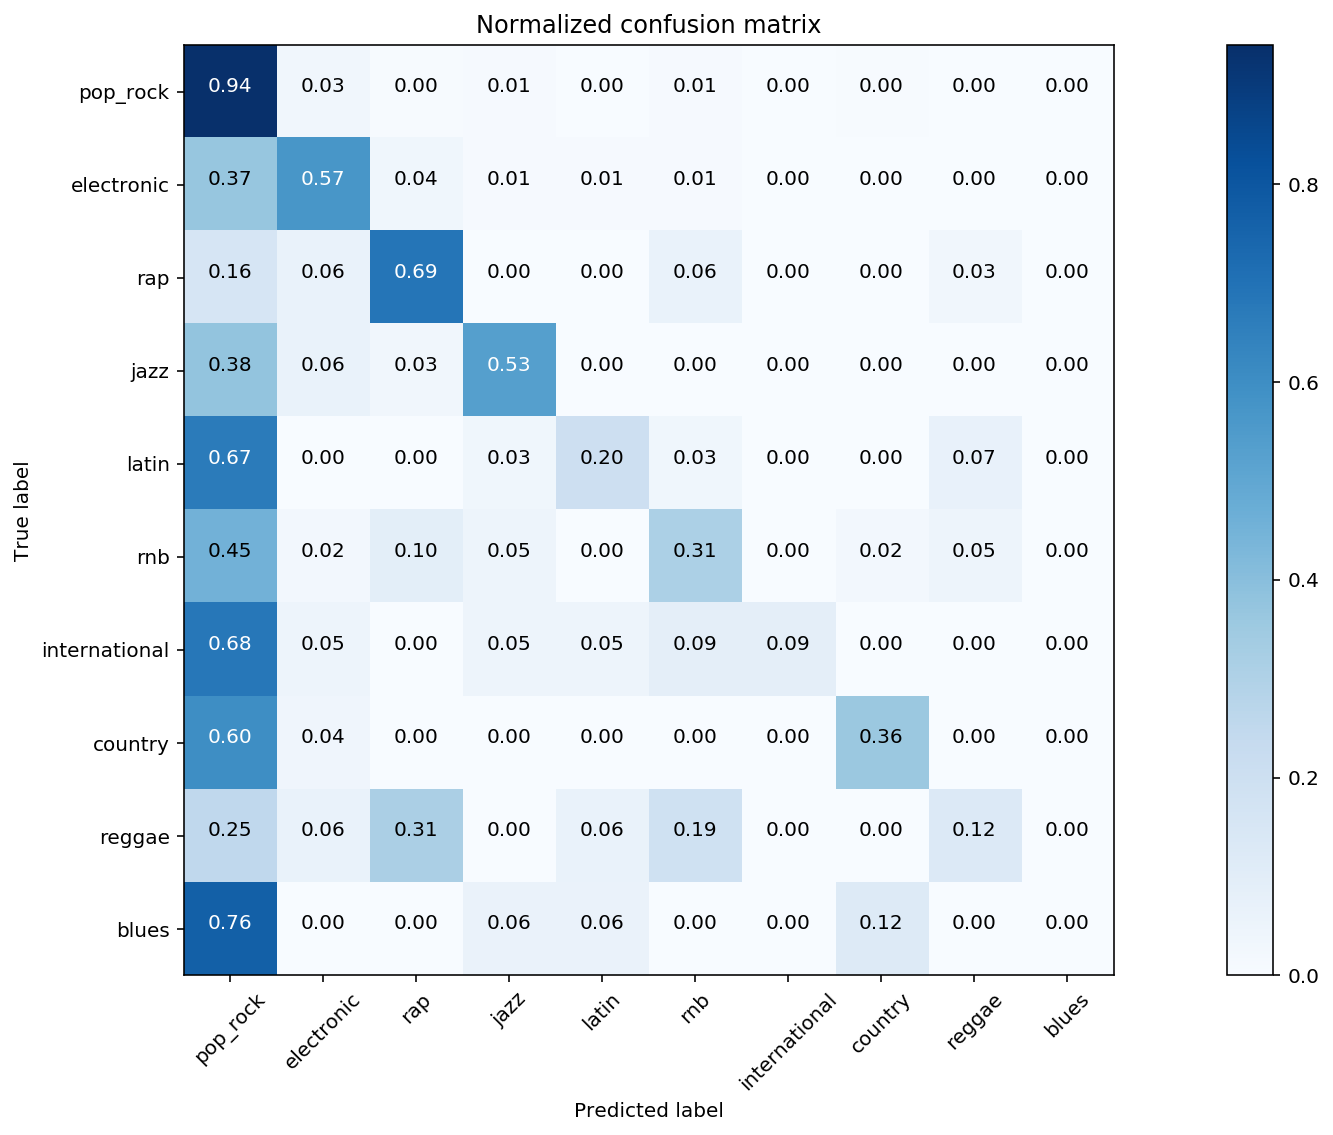

In [28]:
# Function for generating an SVM. Is submit=True, generates Kaggle submission files.
def svm_with_parameters(param_C, param_gamma, submit=False, usePCA=False):
    if submit == False:
        if usePCA:
            feature_matrix = np.zeros(labeled_pca_train_matrix.shape)
            for i in range(labeled_pca_train_matrix.shape[0]):
                for j in range(labeled_pca_train_matrix.shape[1]):
                    feature_matrix[i, j] = labeled_pca_train_matrix[i, j]
        else:
            feature_matrix = np.zeros(labeled_train_matrix.shape)
            for i in range(labeled_train_matrix.shape[0]):
                for j in range(labeled_train_matrix.shape[1]):
                    feature_matrix[i, j] = labeled_train_matrix[i, j]
        np.random.seed(244)
        np.random.shuffle(feature_matrix)
        X_train = feature_matrix[:3600,0:-1]
        y_train = feature_matrix[:3600,-1]
        X_test = feature_matrix[3600:,0:-1]
        y_test = feature_matrix[3600:,-1]
        clf = svm.SVC(C=param_C, gamma=param_gamma)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        # Plot Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(16,8))
        plot_confusion_matrix(cm, classes=genres.keys(), normalize=True, title='Normalized confusion matrix')
        print("Accuracy score on test data:", accuracy_score(y_test, y_pred))
    else:
        if usePCA:
            feature_matrix = np.zeros(labeled_pca_train_matrix.shape)
            for i in range(labeled_pca_train_matrix.shape[0]):
                for j in range(labeled_pca_train_matrix.shape[1]):
                    feature_matrix[i, j] = labeled_pca_train_matrix[i, j]
        else:
            feature_matrix = np.zeros(labeled_train_matrix.shape)
            for i in range(labeled_train_matrix.shape[0]):
                for j in range(labeled_train_matrix.shape[1]):
                    feature_matrix[i, j] = labeled_train_matrix[i, j]
        np.random.seed(244)
        np.random.shuffle(feature_matrix)
        X_train = feature_matrix[:,0:-1]
        y_train = feature_matrix[:,-1]
        X_test = test_matrix
        clf = svm.SVC(C=param_C, gamma=param_gamma, probability=True)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        pred_prob = clf.predict_proba(X_test)
        print_kaggle_accuracy_format(y_pred.astype(int))
        print_kaggle_logloss_format(pred_prob)
        print("Kaggle submissions ready.")


svm_with_parameters(3.2, 0.0025, submit=False, usePCA=False)

The best performing classifier scored $0.65766$ on accuracy metric in Kaggle. On the LogLoss metric, the best performing classifier scored $0.16711$.

The performance against Kaggle's data is surprisingly near the performance seen when testing against the available validation data. One conclusion is that the testing data in Kaggle is distributed in the same way as our testing data. This made designing and validating the classifier a lot easier as the submission frequency is limited in Kaggle competitions.

## 5. Discussion/Conclusions

### 5.1 Explanation of results

In the above confusion matrix a heavy concentration on pop_rock genre can be observed. This is largely due to the heavily skewed class distribution. Consider the colorful visualization of samples in two-dimensional space. For example, blues class has a small sample size and the samples lie on the densest part of the scatter plot. Thus it is logical that blues genre is classified incorrectly very easily. In fact, given the skew of the class distribution, it is almost beneficial to "guess" pop_rock as that is the most represented class in the training (and most evidently) also in the testing data. In particular, guessing only pop_rock yields around $50\%$ classification score. This results in a lot of false positives for pop_rock, which can be determined from the high probability density in the first column of the confusion matrix above.


### 5.2 Relevance of performance results

The performance against Kaggle's data is surprisingly near the performance seen when testing against the available validation data. This made designing and validating the classifier a lot easier as the submission frequency is limited in Kaggle competitions. Accuracy test measures the number of correct predictions. It can be calculated by taking correct predictions divided by the total amount of datapoints. Usually the value is presented in percentages. LogLoss test is giving a likelihood for each datapoint of belonging to each class. This means that the result matrix is the number of data samples times the number of classes.

### 5.3 Relation to literature

There are many research papers about music genre classification with support vector machine. This tells us that the SVM method is widely used and a good approach for this specific problem. According to Guo (2003) experimental results show that Support Vector Machines can be trained effectively in case of audio classification problem. Selecting the proper kernel function and right values for the tuning parameters play extremely important role in solving this kind of problem (Xu, 2003).

### 5.4 Further improvements

Interesting future research topics would be how to incorporate principal component analysis to the dataset in order to improve the accuracy and reduce the computing burden of finding a good classifier. In this research, PCA was not able to improve the classifying accuracy. Further improvements could be made by researching if using different classifiers for different features would improve the accuracy of the predictions or not. Another issue worth further research would be training the classifier with more balanced dataset. In this research, the class distribution is heavily skewed which resulted in poor classification performance in genres with low number of training samples.

### 5.5 Final conclusion

As a conclusion, out of all the different classifiers we studied, SVM with RBF kernel produced the best solution to this specific problem.


## 6. References

Bertin-Mahieux, T., Ellis, D., Whitman, B. & Lamere, P., 2011. The Million Song Dataset. ISMIR. Available from: https://labrosa.ee.columbia.edu/millionsong/.

Fraj, M., 2018. In Depth: Parameter tuning for SVC [online]. [viewed 1 November 2018]. Available from: https://medium.com/all-things-ai/in-depth-parameter-tuning-for-svc-758215394769

Ganchev, T., Fakotakis, N. & Kokkinakis, G., 2005. Comparative evaluation of various MFCC implementations on the speaker verification task. Proceedings of the SPECOM. Vol. 1, pp.191–194.

Guo, G. & Li, S., 2003. Content-based audio classification and retrieval by support vector machines. IEEE transactions on Neural Networks, 14(1), pp.209-215.

Jung, A., 2018. MLBP Data Analysis Project - Problem Description [online]. [viewed 30 October 2018]. Available from: https://mycourses.aalto.fi/pluginfile.php/743413/mod_resource/content/14/MLBP%202018%20project%20description.pdf

Lidy, T., 2007. Audio Feature Extraction - Rhythm Patterns [online]. [viewed 30 October 2018]. Available from: http://ifs.tuwien.ac.at/mir/audiofeatureextraction.html

Scikit-learn, 2018. Sklearn preprocessing StandardScaler [online]. [viewed 30 October 2018]. Available from: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

Scikit-learn, 2018. Sklearn svm SVC [online]. [viewed 30 October 2018]. Available from: http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

Scikit-learn, 2018. Choosing the right estimator [online]. [viewed 1 November 2018]. Available from: http://scikit-learn.org/stable/tutorial/machine_learning_map/

Xu, C., Maddage, N., Shao, X., Cao, F. and Tian, Q., 2003. Musical genre classification using support vector machines. Proceedings of the ICASSP. IEEE. Vol. 5, pp.V-429.